In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

# Задание 1

Подобрать таблицу данных с несбалансированными классами. Решить задачу классификации любым подходящим методом.

In [91]:
df = pd.read_csv('../mushrooms.csv')

counts = df['class'].value_counts()
p_counts, e_counts = counts

counts

e    4208
p    3916
Name: class, dtype: int64

In [92]:
p_indices = df[df['class'] == 'p'].index

new_p_percent = 0.4

drop_p_count = int(p_counts * (1.0 - new_p_percent))

mask = np.random.choice(p_indices, drop_p_count, replace=False)
mask.sort()

df_disb = df.drop(mask, axis=0)

df_disb['class'].value_counts()

e    4208
p    1392
Name: class, dtype: int64

In [93]:
df_disb.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m


In [94]:
df_enc = df_disb.transform(lambda x: LabelEncoder().fit_transform(x))
df_enc.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
5,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
6,0,0,2,8,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,2,3


In [95]:
X = df_enc.drop(['class'], axis=1).to_numpy()
y = df_enc['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [96]:
logreg = LogisticRegression(solver='newton-cg')

logreg.fit(X_train, y_train)
y_probs = logreg.predict_proba(X_test)[:, 1]

print('Accuracy: ', logreg.score(X_test, y_test))

Accuracy:  0.9553571428571429


# Задание 2

 Вычислить точность, полноту, специфичность.

In [97]:

def metrics(y_pred: np.ndarray, y_gt: np.ndarray):
  return {
    'TP': np.count_nonzero(np.logical_and(y_pred == 1, y_gt == 1)),
    'TN': np.count_nonzero(np.logical_and(y_pred == 0, y_gt == 0)),
    'FP': np.count_nonzero(np.logical_and(y_pred == 1, y_gt == 0)),
    'FN': np.count_nonzero(np.logical_and(y_pred == 0, y_gt == 1))
  }

def true_pos_rate(metrics):
  '''
  Recall or TPR
  '''
  return metrics['TP'] / (metrics['TP'] + metrics['FN'])

def false_pos_rate(metrics):
  return metrics['FP'] / (metrics['TN'] + metrics['FP'])

def precision(metrics):
  return metrics['TP'] / (metrics['TP'] + metrics['FP'])

def specificity(metrics):
  return metrics['TN'] / (metrics['TN'] + metrics['FP'])

def _get_curve_impl(y_prob: np.ndarray, y_ground_truth: np.ndarray, thresholds: np.ndarray, x_func, y_func):
   x = np.zeros_like(thresholds)
   y = np.zeros_like(thresholds)
   for i, threshold in enumerate(sorted(thresholds, reverse=True)):
       y_predict = y_prob >= threshold
       met = metrics(y_predict, y_ground_truth)
       x[i] = x_func(met)
       y[i] = y_func(met)
   return x, y

def get_roc_curve(y_prob: np.ndarray, y_ground_truth: np.ndarray):
  '''
  returns: FPR, TPR
  '''
  thresholds = np.concatenate(([0.], y_prob, [1.]))
  return _get_curve_impl(y_prob, y_ground_truth, thresholds, false_pos_rate, true_pos_rate)


def get_pr_curve(y_prob: np.ndarray, y_ground_truth: np.ndarray):
  '''
  returns: recall, precision
  '''
  rec, pre = _get_curve_impl(y_prob, y_ground_truth, y_prob, true_pos_rate, precision)
  return np.concatenate(([0.], rec)), np.concatenate(([1.], pre))


def auc(x_vals, y_vals):
  return np.trapz(y_vals, x_vals)


In [98]:
y_pred = logreg.predict(X_test)
test_metrics = metrics(y_pred, y_test)
print(*map(lambda t: f'{t[0]} = {t[1]}', test_metrics.items()), sep='\n')

TP = 388
TN = 1217
FP = 22
FN = 53


In [99]:
pattern = '{0} = {1:.2f} %'
print(pattern.format('Recall', true_pos_rate(test_metrics) * 100))
print(pattern.format('Precision', precision(test_metrics) * 100))
print(pattern.format('Specificity', specificity(test_metrics) * 100))

Recall = 87.98 %
Precision = 94.63 %
Specificity = 98.22 %


# Задание 3

Построить кривую ошибок и найти площадь под ней. Построить для сравнения кривую 'точность-полнота'.

In [100]:
def plot_curve(x, y, x_label, y_label, title, legend='', new_figure=True):
  
  if new_figure:
    plt.figure(figsize=(10, 6), dpi=100)
    plt.title(title)
    plt.plot([0, 1], [0, 1], alpha = 0.3, color = 'black')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.grid()
  
  plt.plot(x, y, label=legend)

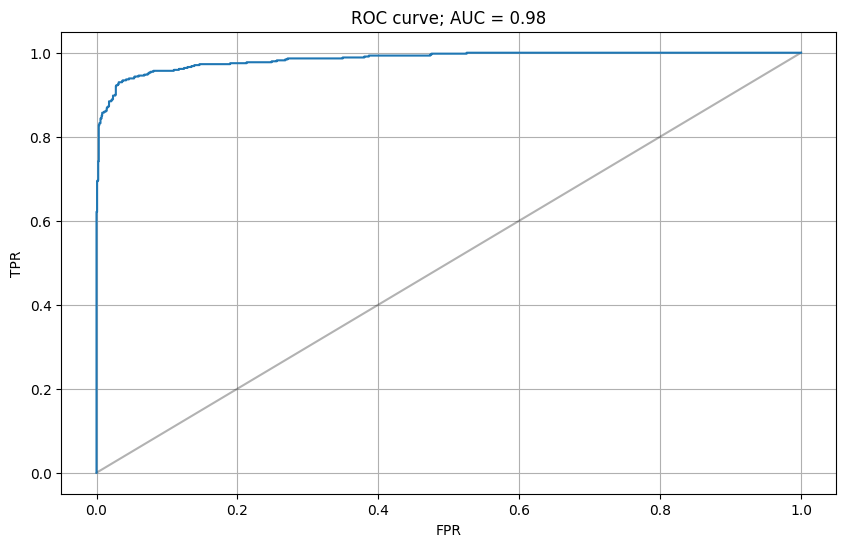

In [101]:
roc_curve = get_roc_curve(y_probs, y_test)
rock_auc = auc(*roc_curve)
plot_curve(*roc_curve, 'FPR', 'TPR', f'ROC curve; AUC = {rock_auc:.2f}')

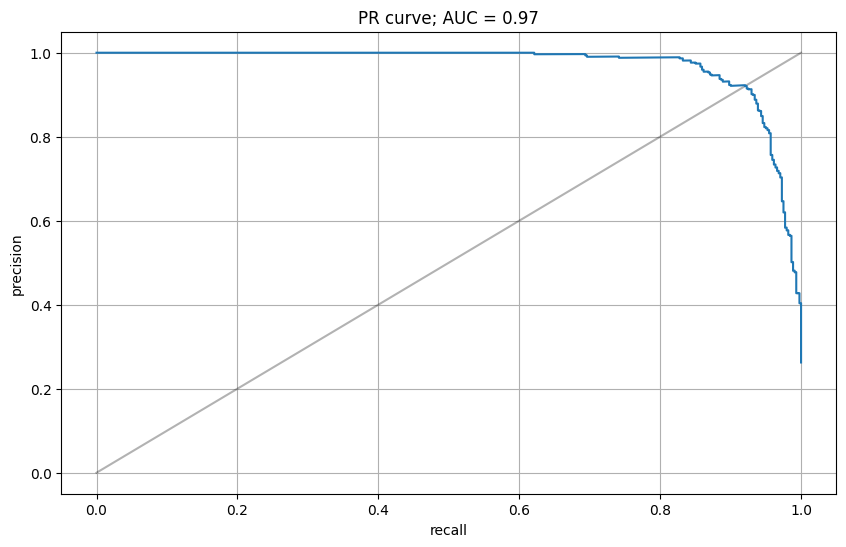

In [102]:
pr_curve = get_pr_curve(y_probs, y_test)
plot_curve(*pr_curve, 'recall', 'precision', f'PR curve; AUC = {auc(*pr_curve):.2f}')

# Задание 4
Разбить данные на обучающую и контрольную выборки. Построить ROC- кривую для каждой из подвыборок. Построить ROC- кривую на основе кроссвалидации.

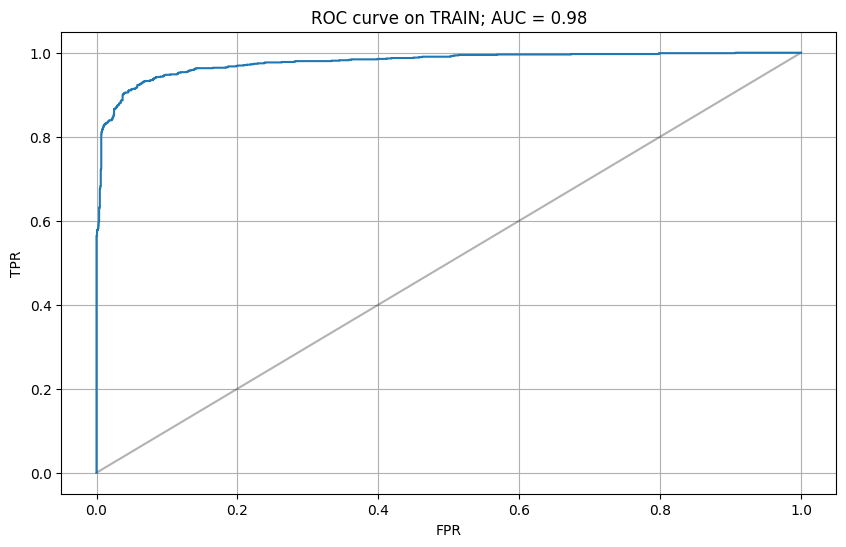

In [103]:
y_probs_train = logreg.predict_proba(X_train)[:, 1]
rock_curve_train = get_roc_curve(y_probs_train, y_train)
plot_curve(*rock_curve_train, 'FPR', 'TPR', f'ROC curve on TRAIN; AUC = {auc(*rock_curve_train):.2f}')

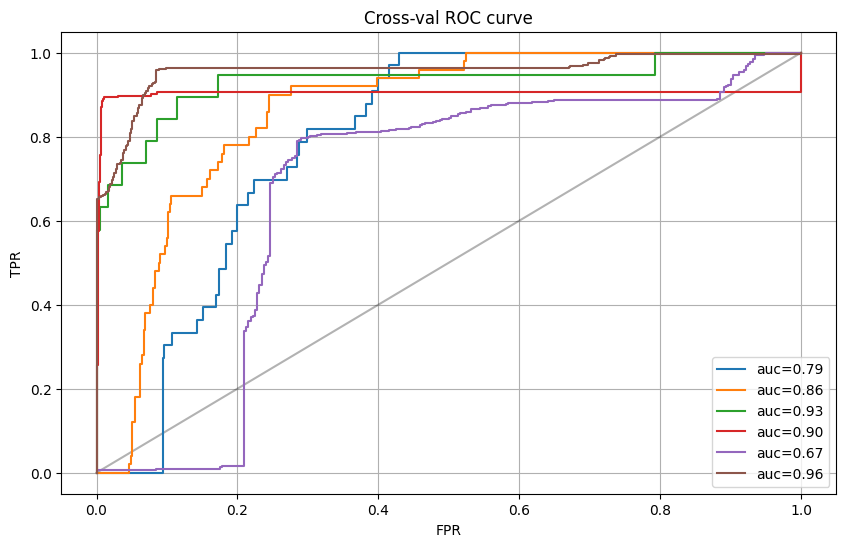

In [104]:
clf = LogisticRegression(solver='newton-cg')
cv = KFold(n_splits=6)

plt.figure(figsize=(10, 6), dpi=100)
plt.title('Cross-val ROC curve')
plt.plot([0, 1], [0, 1], alpha = 0.3, color = 'black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')


for train, test in cv.split(X, y):
  clf.fit(X[train], y[train])
  y_gt = y[test]
  y_pred_probs = clf.predict_proba(X[test])[:, 1]
  
  rock_curve = get_roc_curve(y_pred_probs, y_gt)
  roc_auc = auc(*rock_curve)
  
  plt.plot(*rock_curve, label=f'auc={roc_auc:.2f}')
  
  
plt.grid()
plt.legend();

# Задание 5
Исследовать влияние выбора критерия обучения на AUC. Один из критериев — log loss, ещё один или два — на выбор. Как вариант: сравнить AdaBoost с градиентным бустингом.

In [105]:
def plot_for_models(models):
  for i, model in enumerate(models):
    model.fit(X_train, y_train)

    y_pred_probs = model.predict_proba(X_test)[:, 1]
    roc_curve = get_roc_curve(y_pred_probs, y_test)
    roc_auc = auc(*roc_curve)
    
    plot_curve(*roc_curve, 'FPR', 'TPR', f'ROC curves', f'{str(model)}\n AUC={roc_auc:.2f}', i == 0)


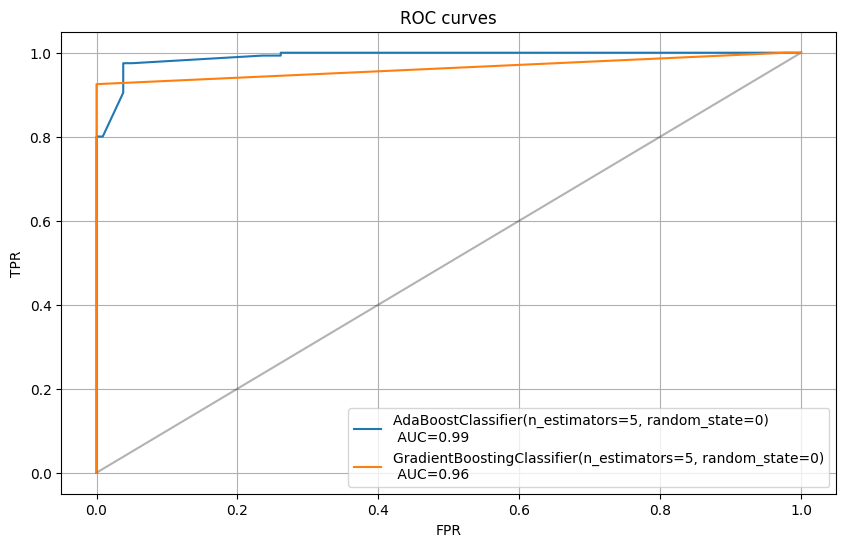

In [108]:
models = [AdaBoostClassifier(n_estimators=5, random_state=0), GradientBoostingClassifier(n_estimators=5,  random_state=0)]

plot_for_models(models)
plt.legend();

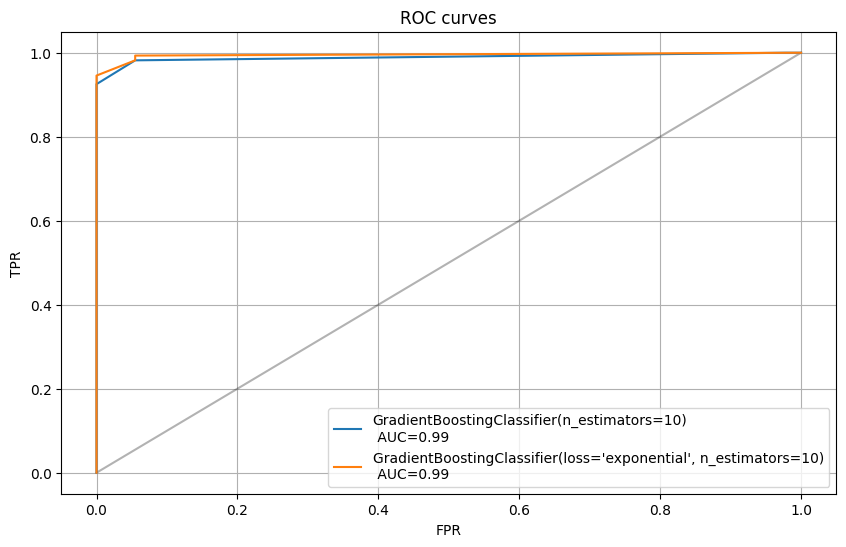

In [111]:
models = [
  GradientBoostingClassifier(n_estimators=10, loss='log_loss'),
  GradientBoostingClassifier(n_estimators=10, loss='exponential'),
]

plot_for_models(models)
plt.legend();

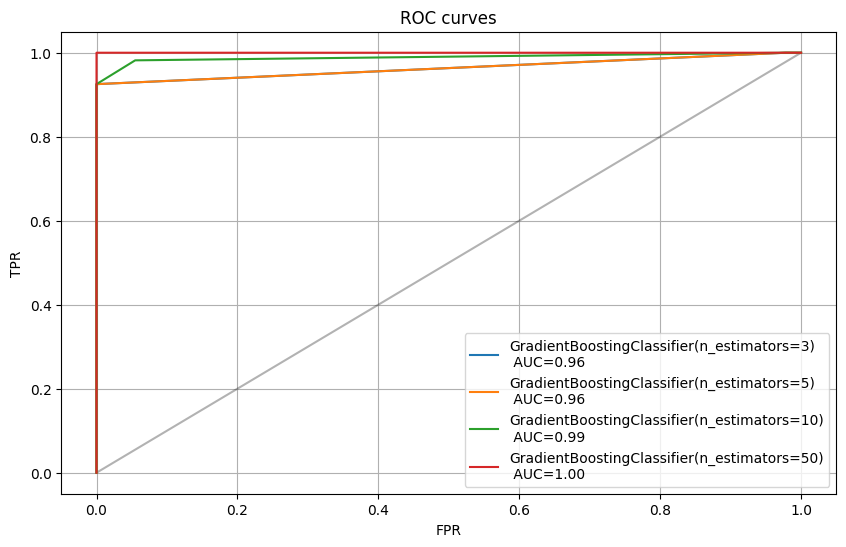

In [115]:
models = [GradientBoostingClassifier(n_estimators=i) for i in [3, 5, 10, 50]]
plot_for_models(models)
plt.legend();